## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [1]:
!pip install pytorch-lightning transformers torch torchvision matplotlib opencv-python h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE= 256 if torch.cuda.is_available() else 64
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, download=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, download=True, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
import numpy as np


mnist = MNISTDataModule()
mnist.setup()

images, labels = next(iter(mnist.train_dataloader()))



In [ ]:
class Annotated_MNIST():

    def __init__(self, train=False):

        if train:
            self.batches = mnist.train_dataloader()
        else:
            self.batches = mnist.test_dataloader()

        images, labels = next(iter(self.batches))
        self.labels = labels.numpy()
        self.images = images.numpy().reshape(-1, 28, 28)

        self.nwords = 6
        self.vocab_size = 19
        self.mnist_settings = {0: {'bound': 10, 'skew_range': 60, 'mean': 8, 'line': 14, 'thickness_range': 2}, \
                               1: {'bound': 6, 'skew_range': 25, 'mean': 4, 'line': 20, 'thickness_range': 1},  \
                               2: {'bound': 10, 'skew_range': 60, 'mean': 5, 'line': 11, 'thickness_range': 2}, \
                               3: {'bound': 14, 'skew_range': 20, 'mean': 5, 'line': 18, 'thickness_range': 2}, \
                               4: {'bound': 20, 'skew_range': 50, 'mean': 8, 'line': 10, 'thickness_range': 2}, \
                               5: {'bound': 10, 'skew_range': 30, 'mean': 8, 'line': 20, 'thickness_range': 6}, \
                               6: {'bound': 10, 'skew_range': 25, 'mean': 5, 'line': 7, 'thickness_range': 2},  \
                               7: {'bound': 6, 'skew_range': 20, 'mean': 4, 'line': 22, 'thickness_range': 0},  \
                               8: {'bound': 12, 'skew_range': 25, 'mean': 9, 'line': 10, 'thickness_range': 2}, \
                               9: {'bound': 10, 'skew_range': 30, 'mean': 4, 'line': 22, 'thickness_range': 0}}

        self.word2idx = {'thin': 0, 'normal': 1, 'thick': 2, \
                         'number': 3, \
                         'zero': 4, 'one': 5, 'two': 6, 'three': 7, 'four': 8, 'five': 9, 'six': 10, 'seven': 11, 'eight': 12, 'nine': 13, \
                         'with': 14, \
                         'left': 15, 'average': 16, 'right': 17, \
                         'skew': 18}

        self.idx2word = {idx: word for (word, idx) in self.word2idx.items()}


    def get_nums(self, num):
        idx = np.where(self.labels == num)[0]
        nums = self.images[idx]
        return idx, nums


    def thickness_stats(self, num, line, thickness_range):
        idx, nums = self.get_nums(num)

        m = int(np.mean(np.sum(nums[:, line, :] != 0, axis=1)))
        t_lb = int(m - thickness_range / 2)
        t_ub = int(m + thickness_range / 2)

        l_idx = np.where(np.sum(nums[:, line, :] != 0, axis=1) < t_lb)
        n_idx = np.where(np.logical_and(np.sum(nums[:, line, :] != 0, axis=1) >= t_lb, np.sum(nums[:, line, :] != 0, axis=1) <= t_ub))
        h_idx = np.where(np.sum(nums[:, line, :] != 0, axis=1) > t_ub)

        l_idx = idx[l_idx]
        n_idx = idx[n_idx]
        h_idx = idx[h_idx]

        print('Low: {}\nNormal: {}\nHigh: {}\n'.format(len(l_idx), len(n_idx), len(h_idx)))

        return l_idx, n_idx, h_idx


    def get_thickness(self, img, mean, line, thickness_range):
        t_lb = int(mean - thickness_range / 2)
        t_ub = int(mean + thickness_range / 2)

        if np.sum(img[line, :] != 0) < t_lb:
            return 'thin'
        elif np.logical_and(np.sum(img[line, :] != 0) >= t_lb, np.sum(img[line, :] != 0) <= t_ub):
            return 'normal'
        else:
            return 'thick'


    def __rotate_and_scale(self, img, angle, scale):
        M = cv2.getRotationMatrix2D((14, 14), angle, scale)
        return cv2.warpAffine(img, M, (28, 28))


    def skew_stats(self, num, bound, skew_range):
        lb = int(14 - bound / 2)
        ub = int(14 + bound / 2)
        s_lb = -int(skew_range / 2)
        s_ub = int(skew_range / 2)

        idx, nums = self.get_nums(num)

        skews = []
        for num in nums:

            li = []
            max_overlap = 0
            max_angle = 0
            for angle in range(-90, 90, 5):
                temp1 = self.__rotate_and_scale(num, angle, 1)
                temp2 = temp1[:, lb:ub]

                if max_overlap <= np.sum(temp2 != 0):
                    max_overlap = np.sum(temp2 != 0)
                    max_angle = angle

            skews.append(max_angle)

        skews = np.array(skews)
        l_idx = np.where(skews < s_lb)
        n_idx = np.where(np.logical_and(skews >= s_lb, skews <= s_ub))
        h_idx = np.where(skews > s_ub)

        l_idx = idx[l_idx]
        n_idx = idx[n_idx]
        h_idx = idx[h_idx]

        print('Low: {}\nNormal: {}\nHigh: {}\n'.format(len(l_idx), len(n_idx), len(h_idx)))

        return l_idx, n_idx, h_idx


    def get_skew(self, img, bound, skew_range):
        lb = int(14 - bound / 2)
        ub = int(14 + bound / 2)
        s_lb = -int(skew_range / 2)
        s_ub = int(skew_range / 2)

        max_overlap = 0
        max_angle = 0
        for angle in range(-90, 90, 5):
            temp1 = self.__rotate_and_scale(img, angle, 1)
            temp2 = temp1[:, lb:ub]

            if max_overlap <= np.sum(temp2 != 0):
                max_overlap = np.sum(temp2 != 0)
                max_angle = angle

        if max_angle < s_lb:
            return 'left skew'
        elif np.logical_and(max_angle >= s_lb, max_angle <= s_ub):
            return 'average skew'
        else:
            return 'right skew'


    def get_description(self, img, num):

        settings = self.mnist_settings[num]
        bound = settings['bound']
        skew_range = settings['skew_range']
        mean = settings['mean']
        line = settings['line']
        thickness_range = settings['thickness_range']

        skew = self.get_skew(img, bound, skew_range)
        thickness = self.get_thickness(img, mean, line, thickness_range)

        if num == 0:
            number = 'zero'
        elif num == 1:
            number = 'one'
        elif num == 2:
            number = 'two'
        elif num == 3:
            number = 'three'
        elif num == 4:
            number = 'four'
        elif num == 5:
            number = 'five'
        elif num == 6:
            number = 'six'
        elif num == 7:
            number = 'seven'
        elif num == 8:
            number = 'eight'
        else:
            number = 'nine'

        res = thickness + ' number ' + number + ' with ' + skew

        return res


    def next_batch(self, batch_size, resize=False, convert_to_idx=True):
        batch_xs, batch_ys = self.batches.next_batch(batch_size)

        images = np.reshape(batch_xs, [-1, 28, 28])
        labels = batch_ys

        descriptions = []

        for i in range(batch_size):
            img = images[i]
            num = labels[i]
            description = self.get_description(img, num).split()

            if convert_to_idx:
                temp = list(map(self.word2idx.get, description))
                descriptions.append(temp)
            else:
                descriptions.append(description)

        if resize:

            batch_xs = np.reshape(images, [-1, 784])
            images_small = []

            for i in range(batch_size):
                images_small.append(cv2.resize(images[i], (14, 14), interpolation=0))

            images_small = np.array(images_small)
            batch_xs_small = np.reshape(images_small, [-1, 196])
            batch_ys = labels

            return descriptions, batch_xs, batch_xs_small, batch_ys

        else:
            batch_xs = np.reshape(images, [-1, 784])
            batch_ys = labels

            return descriptions, batch_xs, batch_ys


    def generate_sentences(self, num, divide=True, convert_to_idx=True):
        sentences = []

        thickness = ['thin', 'normal', 'thick']
        nums = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
        skew = ['left skew', 'average skew', 'right skew']

        for i in range(num):
            sentence = ''

            sentence += random.choice(thickness)
            sentence += ' number '
            sentence += random.choice(nums)
            sentence += ' with '
            sentence += random.choice(skew)

            if divide:
                sentences.append(sentence.split())
            else:
                sentences.append(sentence)

        if convert_to_idx:

            for i in range(num):
                sentences[i] = list(map(self.word2idx.get, sentences[i]))

            return sentences

        else:

            return sentences


    def convert_to_word(self, sentences, concat=True):
        res = []

        for sentence in sentences:
            res.append(list(map(self.idx2word.get, sentence)))

        if concat:

            for i in range(len(res)):

                sent = ''
                for word in res[i]:
                    sent += word + ' '

                res[i] = str.rstrip(sent)

        return res


    def convert_to_idx(self, sentences):
        res = []

        for sentence in sentences:
            res.append(list(map(self.word2idx.get, sentence.split())))

        return res

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [ ]:
class GAN(pl.LightningModule):
  def __init__(self, latent_dim=100, lr=0.0002):
    super().__init__()
    self.save_hyperparameters()
    self.automatic_optimization=False

    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()

    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx):
    opt_g, opt_d = self.optimizers()
    real_imgs, _ = batch

    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # train generator: max log(D(G(z or random noise)))
    self.toggle_optimizer(opt_g)
    self.generated_imgs = self(z)

    fake_imgs = self(z)
    y_hat = self.discriminator(fake_imgs)

    y = torch.ones(real_imgs.size(0), 1)
    y = y.type_as(real_imgs)

    g_loss = self.adversarial_loss(y_hat, y)

    self.log("g_loss", g_loss, prog_bar=True)
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()
    self.untoggle_optimizer(opt_g)

    # train discriminator max log(D(x)) + log(1 - D(G(z)))
    self.toggle_optimizer(opt_d)

    # how well can it label as real
    y_hat_real = self.discriminator(real_imgs)
    y_real = torch.ones(real_imgs.size(0), 1)
    y_real = y_real.type_as(real_imgs)

    real_loss = self.adversarial_loss(y_hat_real, y_real)

    # how well can it label as fake
    y_hat_fake = self.discriminator(self(z).detach())
    y_fake = torch.zeros(real_imgs.size(0), 1)
    y_fake = y_fake.type_as(real_imgs)

    fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

    d_loss = (real_loss + fake_loss) / 2
    self.log("d_loss", d_loss, prog_bar=True)
    self.manual_backward(d_loss)
    opt_d.step()
    opt_d.zero_grad()
    self.untoggle_optimizer(opt_d)

  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    return [opt_g, opt_d], []

  def plot_imgs(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()

    print('epoch ', self.current_epoch)
    fig = plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2, 3, i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
    plt.show()

  def on_train_epoch_end(self):
    self.plot_imgs()

In [ ]:
dm = MNISTDataModule()
model = GAN()

In [ ]:
trainer = pl.Trainer(max_epochs=100, accelerator='auto')
trainer.fit(model, dm)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Manually save the model's state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/notebooks/GAN/model_state_dict.pth')

# Optionally save the optimizer's state dictionary if needed
optimizer, _ = model.configure_optimizers()
torch.save(optimizer[0].state_dict(), '/content/drive/MyDrive/notebooks/GAN/g_optimizer_state_dict.pth')
torch.save(optimizer[1].state_dict(), '/content/drive/MyDrive/notebooks/GAN/d_optimizer_state_dict.pth')

In [ ]:
def generate_samples(generator, num_samples):
    noise = torch.randn(num_samples, generator.hparams.latent_dim)  # Assuming latent_dim is the dimension of your input noise vector
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    return generated_images

In [ ]:
from typing import Any, Dict, List, Optional
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast

DEFAULT_MODEL_NAME = "openai/clip-vit-base-patch32"
DEFAULT_DEVICE = "cpu"

class ClipEmbeddings():

  def __init__(self, **kwargs: Any):

    self.model_name: str = DEFAULT_MODEL_NAME
    self.device: str = DEFAULT_DEVICE
    self.model = CLIPModel.from_pretrained(self.model_name).to(self.device)
    self.tokenizer = CLIPTokenizerFast.from_pretrained(self.model_name)
    self.processor = CLIPProcessor.from_pretrained(self.model_name)

  def embed_query(self, text: str) -> List[float]:
    inputs = self.tokenizer(text, return_tensors="pt").input_ids
    text_emb = self.model.get_text_features(inputs.to(self.device))
    return text_emb.tolist()[0]

In [ ]:
device = f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
clip = ClipEmbeddings(model_name="openai/clip-vit-base-patch32", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

def tensor_to_pil_img(img):
    img = (img - img.min()) / (img.max() - img.min())

    # If needed, rescale to [0, 255] and convert to uint8
    img = img * 255
    img = img.to(torch.uint8)

    # Convert the tensor to a PIL image
    transform = transforms.ToPILImage()
    img = transform(img)
    return img

def compute_clip_loss(img, text):
    # tokenized_text = embed_model.embed_query(text)
    inputs = clip.processor(
        text=[text], images=img, return_tensors="pt", padding=True
    )
    outputs = clip.model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    # img_logits, _text_logits = clip.model(img, tokenized_text)
    return 1/logits_per_image * 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


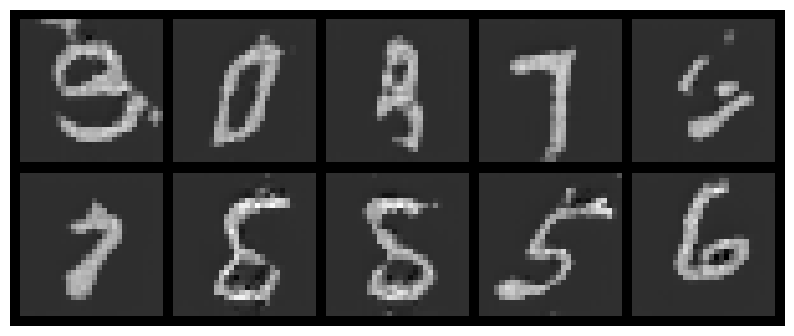

In [ ]:
loaded_model = GAN()
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/notebooks/GAN/model_state_dict.pth'))
num_samples = 10
generated_images = generate_samples(loaded_model, num_samples)
img_grid = torchvision.utils.make_grid(generated_images, nrow=5, normalize=True)
img_grid_np = img_grid.numpy()
img_grid_np = img_grid_np.transpose((1, 2, 0))

plt.figure(figsize=(10, 10))
plt.imshow(img_grid_np)
plt.axis('off')
plt.show()

In [ ]:
optimizer, _ = loaded_model.configure_optimizers()
optimizer = optimizer[0]

In [ ]:
prompt = "give me 1"
img_save_freq = 5

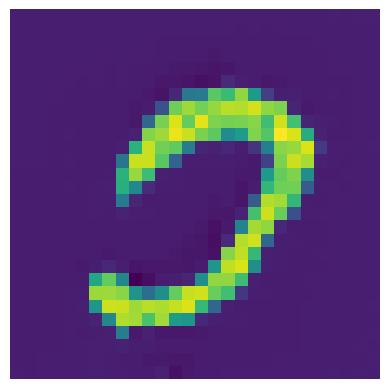

Step 0
Loss 4.520568370819092


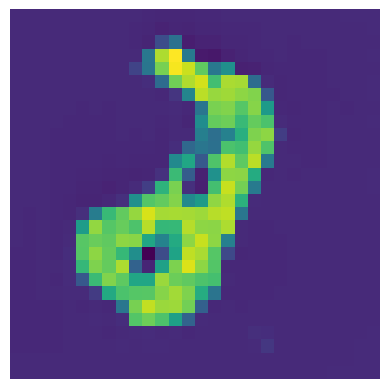

Step 5
Loss 4.70583963394165


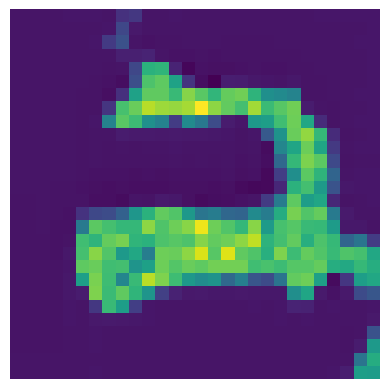

Step 10
Loss 4.8205790519714355


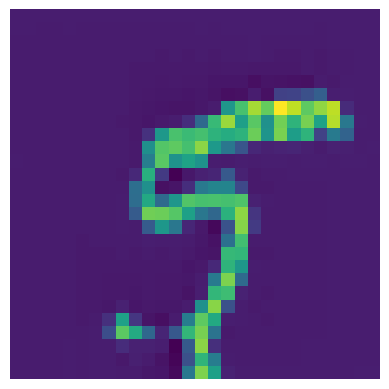

Step 15
Loss 4.717415809631348


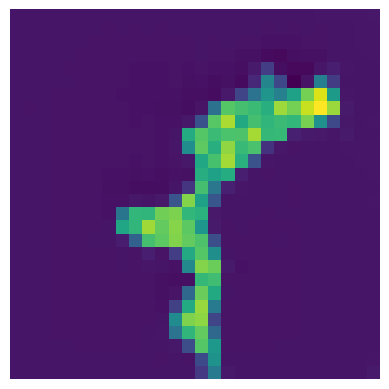

Step 20
Loss 4.779141902923584


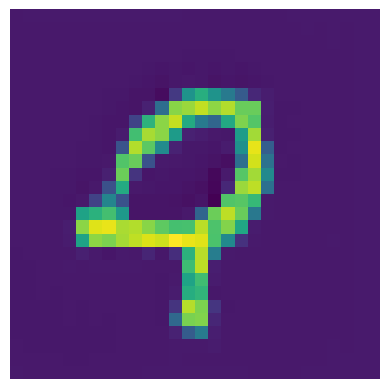

Step 25
Loss 4.5788960456848145


KeyboardInterrupt: 

In [ ]:
counter = 0
while True:
    img = generate_samples(loaded_model, 1)[0]

    # NOTE: clip normalization did not seem to have much effect
    # img = clip_normalize(img)
    # print(img)
    img = tensor_to_pil_img(img)
    loss = compute_clip_loss(img, prompt)

    # NOTE: uncomment to use perceptual loos. Still WIP. You will need to define
    # the `ref_img_path` to use it. The image referenced will be the one
    # used to condition the generation.
    # perceptual_loss = compute_perceptual_loss(img, ref_img)
    # loss = loss + perceptual_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if counter % img_save_freq == 0:
        # Display the image using Matplotlib
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
        print(f'Step {counter}')
        print(f'Loss {loss.data.cpu().numpy()[0][0]}')

    counter += 1